In [13]:
using SeisNoise, SeisIO, Plots
using Dates 
using Plots
using SeisDvv
using CSV
using Statistics
using LinearAlgebra
using Deconvolution


# Function to create an evenly spaced array
function evenly_spaced(a, b, n)
    h = (b - a) / (n - 1)
    collect(a:h:b)
end


# Averaging function for causal and acausal parts
function average_causal_acausal(corr, time)
    averaged_corr = copy(corr)
    causal_index = findfirst(time .>= 0)
    acausal_index = findlast(time .< 0)

    for k in 1:causal_index-1
        if acausal_index - k + 1 > 0
            averaged_corr[causal_index + k - 1] = (averaged_corr[acausal_index - k + 1] + averaged_corr[causal_index + k - 1]) / 2
        end
    end

    return averaged_corr
end

average_causal_acausal (generic function with 1 method)

In [ ]:
cross_corr_data = dailystk.corr

# Determine the indices for the noise-dominant sections
# For instance, taking sections far from the peak
num_points = size(cross_corr_data, 1)
middle = div(num_points, 2)
noise_section_indices = 1:(middle - 100)  # Example: avoiding 100 points around the peak

# Extract the noise section
noise_section = cross_corr_data[noise_section_indices, :]

# Calculate the variance (noise power) across all correlations
# You might want to average this over all the available correlations
noise_power = mean(var(noise_section, dims=1))

In [ ]:
# Define the ncf_denoise function
function ncf_denoise(img_to_denoise::Matrix{Float32}, mdate::Int64, ntau::Int64, nsv::Int64, nsv_to_rm::Int64, use_wiener::Bool, noise_power::Float64)
    m, n = size(img_to_denoise)
    nsv = min(nsv, m, n)

    U, s, V = svd(img_to_denoise)
    Xwiener = zeros(Float32, size(img_to_denoise))  # Ensure the type is Float32

    for kk in (nsv_to_rm + 1):nsv
        SV = Diagonal([kk == i ? s[kk] : 0 for i in 1:min(m, n)])

        X = U * SV * V'

        if use_wiener
            # Convert X to Float64 if necessary
            X64 = convert(Matrix{Float64}, X)
            Xwiener += wiener(X64, X64, noise_power)
        else
            Xwiener += X
        end
    end

    if use_wiener
        # Final Wiener filter application, converting Xwiener to Float64
        Xwiener64 = convert(Matrix{Float64}, Xwiener)
        return wiener(Xwiener64, Xwiener64, noise_power)
    else
        return Xwiener
    end
end

# Preprocess your data
mnf = 0.1
mxf = 0.3
ndaystack = 10
inter = Day(ndaystack)

d = load_corr("/data/wsd02/maleen_data/C_test/OO.HYSB1..BHZ.OO.HYSB1..BHE.jld2", "ZE")
allstk = stack(d, allstack=true)
clean_up!(allstk, mnf, mxf)
abs_max!(allstk)
dailystk = stack(d, interval=inter)
clean_up!(dailystk, mnf, mxf)
abs_max!(dailystk)

# Denoise allstk and dailystk and store in the corrdata
mdate = 5
ntau = 5
nsv = 25
nsv_to_rm = 0
use_wiener = true

# Estimate of the noise power (adjust based on your data)
noise_power = 0.03  # Example value, adjust as needed

allstk.corr = ncf_denoise(allstk.corr, mdate, ntau, nsv, nsv_to_rm, use_wiener, noise_power);
dailystk.corr = ncf_denoise(dailystk.corr, mdate, ntau, nsv, nsv_to_rm, use_wiener, noise_power);

In [14]:
mnf = 0.1
mxf = 0.3
ndaystack = 10
inter = Day(ndaystack)

d=load_corr("/data/wsd02/maleen_data/C_test/OO.HYSB1..BHZ.OO.HYSB1..BHE.jld2","ZE")
#d=load_corr("/data/wsd02/maleen_data/Correl_seismic/OO.HYSB1..BHZ.OO.HYSB1..BHE.jld2","ZE")
allstk=stack(d,allstack=true)
clean_up!(allstk,mnf,mxf)
abs_max!(allstk)
dailystk=stack(d,interval=inter)
clean_up!(dailystk,mnf,mxf)
abs_max!(dailystk)

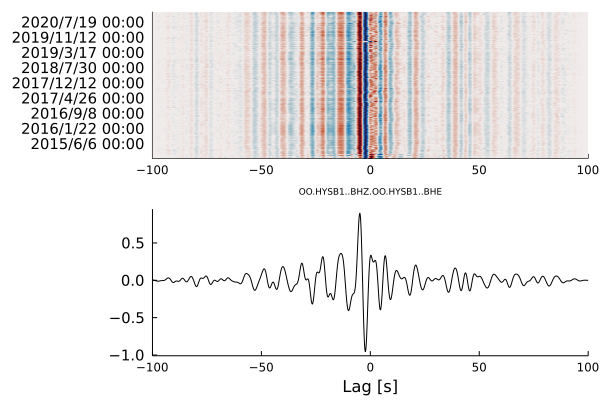

In [15]:
plot(dailystk)

### shifting peaks

In [ ]:
time=evenly_spaced(-100,100,size(dailystk.corr,1))
# Function to find the index of zero-lag peak
function find_zero_lag_peak_index(signal, time)
    zero_lag_index = findfirst(x -> x == 0, time)
    #zero_lag_index = 3800
    window_size = 50 # Adjust this window size as needed
    window_indices = max(1, zero_lag_index - window_size):min(length(signal), zero_lag_index + window_size)
    peak_index = argmax(signal[window_indices]) + window_indices[1] - 1
    return peak_index
end

# The reference signal from allstk
S1 = allstk.corr[:, 1] # Always use the first column of allstk.corr

# Loop through each correlation function in dailystk
for i in 1:size(dailystk.corr, 2)
    S2 = dailystk.corr[:, i]

    peak_index_S1 = find_zero_lag_peak_index(S1, time)
    peak_index_S2 = find_zero_lag_peak_index(S2, time)
    shift_amount = peak_index_S1 - peak_index_S2

    # Shift S2 and pad with zeros
    S2_shifted = circshift(S2, shift_amount)
    if shift_amount > 0
        S2_shifted[1:shift_amount] .= 0
    else
        S2_shifted[end+shift_amount+1:end] .= 0
    end

    # Store the shifted signal back in dailystk.corr
    dailystk.corr[:, i] = S2_shifted
end


In [ ]:
using Plots

time = evenly_spaced(-100, 100, size(allstk.corr, 1))
# Number of correlation functions to plot
num_funcs_to_plot = 75

# Initialize the plot
p = plot(size=(800, 600), legend=false)

# Looping through the first 50 correlation functions
for i in 1:num_funcs_to_plot
    # Accessing the i-th correlation function from the corr matrix
    corr_function = dailystk.corr[:, i]

    # Finding the index of the most minimum value in the correlation function
    min_index = argmin(corr_function)
    min_value = corr_function[min_index]

    # Plotting the correlation function, offsetting each by 'i' for clarity
    plot!(p, time,corr_function .+ i, color=:black, label="Correlation Function $(i)")

    # Adding a short vertical line at the minimum value
    # The line extends slightly above and below the actual minimum point
    line_y_values = [min_value + i - 0.5, min_value + i + 0.5]  # Adjust 0.1 as needed for visibility
    plot!(p, [time[min_index], time[min_index]], line_y_values, color=:red, lw=1,dpi=300)
end

# Setting labels and title
xlabel!(p, "Time Lag")
ylabel!(p, "Correlation Function")
title!(p, "First 50 Stacked Correlation Functions from dailystk with Minima Marked")

# Displaying the plot
display(p)
savefig(p, "dailystacks.png")

In [ ]:
using Plots

# Assuming we have 222 correlation functions in total
total_funcs = length(dailystk)

# Initialize arrays to store the indices (time lags) of minima
min_lag_indices = []

# Extracting the indices (time lags) of the minima
for i in 1:total_funcs
    # Accessing the i-th correlation function from the corr matrix
    corr_function = dailystk.corr[:, i]

    # Finding the index of the most minimum value in the correlation function
    min_index = argmin(corr_function)

    # Including only the indices (time lags) less than or equal to 3950
    if min_index <= 3920
        push!(min_lag_indices, min_index)
    else
        push!(min_lag_indices, NaN)  # Use NaN for values above 3950 to exclude them from the plot
    end
end

# Create the plot with the desired size and explicit margins
p_min_lag = plot(dt, (min_lag_indices/40).-100, title="Time Lag of Minimum Value",
                 xlabel="Correlation Function Number", ylabel="Time Lag of Minimum Value",
                 legend=false, color=:blue, marker=:circle, size=(1000, 400),dpi=300)

# Adjust the margins. Since direct pixel specification is causing an error,
# you can try using `Plots.mm` or `Plots.px` to specify the units.
p_min_lag = plot!(p_min_lag, margin=5Plots.mm)  # This should be equivalent to 5mm margin.

# Save the plot to a file
#savefig(p_min_lag, "min_lag_plot.png")


In [ ]:
a=scatter((min_lag_indices/40).-100,dvt,ylabel="DV/V", xlabel="Time Lag of Minimum Value",size=(1000, 400),dpi=300,margin=5Plots.mm,legend=false)
savefig(a, "lag_dvv plot.png")

In [16]:
fs=40.0     # sample frequency
win_len=5.0  # sliding window length
win_step=2.5 # sliding window step
j=size(dailystk.corr,2)
dvt=zeros(j)
cct=zeros(j)
cctb=zeros(j)
tmin = 37.
tmax = 60.
dmn = -0.01
dmx = 0.01

for i in 1:j
    S1=Array(allstk.corr[:])
    S2=Array(dailystk.corr[:,i])
    rel_tmin_index = Int(floor((tmin + 100) * fs))
    rel_tmax_index = Int(floor((tmax + 100) * fs))

    window = collect(rel_tmin_index:rel_tmax_index)
    fmin = mnf
    fmax = mxf

    function evenly_spaced(a, b, n)
        h = (b-a)/(n-1)
        collect(a:h:b)
    end

    time=evenly_spaced(-100,100,size(dailystk.corr,1))

    dvv_ts, cc_ts, cdp_Ts, eps_ts, err_ts, allC_ts = SeisDvv.stretching(S1, S2, time, window, fmin, fmax, dvmin=dmn, dvmax=dmx, ntrial=1000);
    #dvmin=-0.01, dvmax=0.01
    dvt[i]=dvv_ts
    cct[i]=cc_ts
    cctb[i]=cdp_Ts
    
end

dt = map(unix2datetime, dailystk.t);
# Assuming datetime_vector is your 71-element Vector{DateTime} 
# and float_vector is your 71-element Vector{Float64}
datetime_vector = dt;  # fill this with your data
float_vector = dvt;  # fill this with your data
cctfilter = cct;

# Combine the vectors into a named tuple which CSV.File will interpret as a table
data = (DateTime=datetime_vector, Float=float_vector,cct);

# Set the threshold value
threshold = 0.80

# Filter the datetime and float vectors based on the threshold
filtered_indices = cct .>= threshold;
datetime_vector = datetime_vector[filtered_indices];
float_vector = float_vector[filtered_indices];
cctfilter = cct[filtered_indices];

# Calculate the Interquartile Range (IQR)
Q1 = quantile(float_vector, 0.20)
Q3 = quantile(float_vector, 0.80)
IQR = Q3 - Q1

# Calculate the lower and upper bounds to filter the outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the vectors to remove the outliers
dtf = DateTime[]
dvtf = Float64[]
cctf = Float64[]
for i in 1:length(float_vector)
    if float_vector[i] >= lower_bound && float_vector[i] <= upper_bound
        push!(dtf, datetime_vector[i])
        push!(dvtf, float_vector[i])
        push!(cctf, cctfilter[i])
    end
end
# Calculate the mean and standard deviation
mean_value = mean(cct)
std_deviation = std(dvtf)

# Print the results
println("Mean of the float vector: $mean_value")
println("Standard deviation of the float vector: $std_deviation")

# Sample datetime_vector and dvtf
datetime_vector = dtf

# Find the minimum and maximum dates in the datetime_vector
min_date = minimum(datetime_vector)
max_date = maximum(datetime_vector)

# Generate all dates in the date rangeI'
all_dates = collect(min_date:Day(ndaystack):max_date)

# Find the dates that are in all_dates but not in datetime_vector (considering only the date part)
missing_dates = setdiff(all_dates, datetime_vector)



# Assuming dt, dvt, cct, and dailystk are defined
#dt = map(unix2datetime, dailystk.t)
ticks = dtf[1:10:end]
tick = Dates.format.(ticks, "yyyy-mm-dd")

# First subplot
p1 = plot(scatter(dtf, dvtf), seriestype = :line, xticks = (ticks, tick), xrot = -30, ylabel="dv/v %", legend=false)
plot!(dtf, dvtf, seriestype = :line, xticks = (ticks, tick), xrot = -30, legend=false)
# For each missing date, add a vertical line to the plot
#for date in missing_dates
#    vline!(p1, [DateTime(date)], linecolor=:red, linewidth=2, linealpha=0.5, label="Missing Date")
#end


# Second subplot
p2 = plot(dtf, cctf, seriestype = :line, ylim = [0, 1], label = "cc", xticks = (ticks, tick), xrot = -30, left_margin = 10Plots.mm, ylabel="cc", xlabel="Date", legend=false)
hline!([0.8], label="Threshold", width=2, color=:red) # Adding a horizontal line at y=0.8

# Third subplot
p3 = plot(dailystk, left_margin = 10Plots.mm)

# The layout now specifies a grid of 3 rows and 1 column and gives the third plot even more vertical space compared to the first two.
l = @layout([a{0.3h}; b{0.2h}; c{0.5h}])

# Combine the plots
final_plot = plot(p1, p2, p3, layout = l, size = (1100, 1000), left_margin = 20Plots.mm, right_margin = 5Plots.mm)

# Save the plot
savefig(final_plot, "$(d.name)_t$(tmin)-$(tmax)_freq$(mnf)-$(mxf)_stk$(ndaystack)clip_0.png")


Mean of the float vector: 0.9531751164583294
Standard deviation of the float vector: 0.1887060000811571


## Averaging code

In [ ]:
using SeisNoise, SeisIO, Plots
using Dates
using SeisDvv
using CSV
using Statistics

# Initial setup
mnf = 0.1
mxf = 0.3
ndaystack = 10
inter = Day(ndaystack)

# Load correlation data
#d = load_corr("/data/wsd02/maleen_data/C_test/OO.HYSB1..BHZ.OO.HYSB1..BHN.jld2", "ZN")
d =load_corr("/data/wsd02/maleen_data/C_test/OO.HYSB1..BHZ.OO.HYSB1..BHE.jld2","ZE")
allstk = stack(d, allstack=true)
clean_up!(allstk, mnf, mxf)
abs_max!(allstk)
dailystk = stack(d, interval=inter)
clean_up!(dailystk, mnf, mxf)
abs_max!(dailystk)

# Parameters for DV/V calculation
fs = 40.0     # Sample frequency
tmin = 10.0
tmax = 60.0
dmn = -0.1
dmx = 0.1
j = size(dailystk.corr, 2)

# Initializing arrays for results
dvt = zeros(j)
cct = zeros(j)
cctb = zeros(j)


# Time vector for the correlation function
time = evenly_spaced(-100, 100, size(allstk.corr, 1))

# Apply averaging to S1
S1_averaged = average_causal_acausal(Array(allstk.corr[:]), time)

for i in 1:j
    S2 = Array(dailystk.corr[:,i])

    # Apply averaging to S2
    S2_averaged = average_causal_acausal(S2, time)

    # Define the window for DV/V calculation
    rel_tmin_index = Int(floor((tmin + 100) * fs))
    rel_tmax_index = Int(floor((tmax + 100) * fs))
    window = collect(rel_tmin_index:rel_tmax_index)

    # DV/V calculation using SeisDvv
    dvv_ts, cc_ts, cdp_Ts, eps_ts, err_ts, allC_ts = SeisDvv.stretching(S1_averaged, S2_averaged, time, window, mnf, mxf, dvmin=dmn, dvmax=dmx, ntrial=100)

    # Storing results
    dvt[i] = dvv_ts
    cct[i] = cc_ts
    cctb[i] = cdp_Ts
end

dt = map(unix2datetime, dailystk.t);
# Assuming datetime_vector is your 71-element Vector{DateTime} 
# and float_vector is your 71-element Vector{Float64}
datetime_vector = dt;  # fill this with your data
float_vector = dvt;  # fill this with your data
cctfilter = cct;

# Combine the vectors into a named tuple which CSV.File will interpret as a table
data = (DateTime=datetime_vector, Float=float_vector,cct);

# Set the threshold value
threshold = 0.80

# Filter the datetime and float vectors based on the threshold
filtered_indices = cct .>= threshold;
datetime_vector = datetime_vector[filtered_indices];
float_vector = float_vector[filtered_indices];
cctfilter = cct[filtered_indices];

# Calculate the Interquartile Range (IQR)
Q1 = quantile(float_vector, 0.20)
Q3 = quantile(float_vector, 0.80)
IQR = Q3 - Q1

# Calculate the lower and upper bounds to filter the outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the vectors to remove the outliers
dtf = DateTime[]
dvtf = Float64[]
cctf = Float64[]
for i in 1:length(float_vector)
    if float_vector[i] >= lower_bound && float_vector[i] <= upper_bound
        push!(dtf, datetime_vector[i])
        push!(dvtf, float_vector[i])
        push!(cctf, cctfilter[i])
    end
end
# Calculate the mean and standard deviation
mean_value = mean(cct)
std_deviation = std(dvtf)

# Print the results
println("Mean of the float vector: $mean_value")
println("Standard deviation of the float vector: $std_deviation")

# Sample datetime_vector and dvtf
datetime_vector = dtf

# Find the minimum and maximum dates in the datetime_vector
min_date = minimum(datetime_vector)
max_date = maximum(datetime_vector)

# Generate all dates in the date rangeI'
all_dates = collect(min_date:Day(ndaystack):max_date)

# Find the dates that are in all_dates but not in datetime_vector (considering only the date part)
missing_dates = setdiff(all_dates, datetime_vector)



# Assuming dt, dvt, cct, and dailystk are defined
#dt = map(unix2datetime, dailystk.t)
ticks = dtf[1:10:end]
tick = Dates.format.(ticks, "yyyy-mm-dd")

# First subplot
p1 = plot(scatter(dtf, dvtf), seriestype = :line, xticks = (ticks, tick), xrot = -30, ylabel="dv/v %", legend=false)
plot!(dtf, dvtf, seriestype = :line, xticks = (ticks, tick), xrot = -30, legend=false)
# For each missing date, add a vertical line to the plot
#for date in missing_dates
#    vline!(p1, [DateTime(date)], linecolor=:red, linewidth=2, linealpha=0.5, label="Missing Date")
#end


# Second subplot
p2 = plot(dtf, cctf, seriestype = :line, ylim = [0, 1], label = "cc", xticks = (ticks, tick), xrot = -30, left_margin = 10Plots.mm, ylabel="cc", xlabel="Date", legend=false)
hline!([0.8], label="Threshold", width=2, color=:red) # Adding a horizontal line at y=0.8

# Third subplot
p3 = plot(dailystk, left_margin = 10Plots.mm)

# The layout now specifies a grid of 3 rows and 1 column and gives the third plot even more vertical space compared to the first two.
l = @layout([a{0.3h}; b{0.2h}; c{0.5h}])

# Combine the plots
final_plot = plot(p1, p2, p3, layout = l, size = (1100, 1000), left_margin = 20Plots.mm, right_margin = 5Plots.mm)

# Save the plot
savefig(final_plot, "$(d.name)_t$(tmin)-$(tmax)_freq$(mnf)-$(mxf)_stk$(ndaystack)clip_avg_1.png")


In [ ]:
# Parameters for DV/V calculation
fs = 40.0     # Sample frequency
tmin = 5.0
tmax = 60.0
dmn = -0.1
dmx = 0.1
j = size(dailystk.corr, 2)

# Initializing arrays for results
dvt = zeros(j)
cct = zeros(j)
cctb = zeros(j)

# Function to create an evenly spaced array
function evenly_spaced(a, b, n)
    h = (b - a) / (n - 1)
    collect(a:h:b)
end

# Averaging function for causal and acausal parts
function average_causal_acausal(corr, time)
    averaged_corr = copy(corr)
    causal_index = findfirst(time .>= 0)
    acausal_index = findlast(time .< 0)

    for k in 1:causal_index-1
        if acausal_index - k + 1 > 0
            averaged_corr[causal_index + k - 1] = (averaged_corr[acausal_index - k + 1] + averaged_corr[causal_index + k - 1]) / 2
        end
    end

    return averaged_corr
end

# Time vector for the correlation function
time = evenly_spaced(-100, 100, size(allstk.corr, 1))

# Apply averaging to S1
S1_averaged = average_causal_acausal(Array(allstk.corr[:]), time)

for i in 1:j
    S2 = Array(dailystk.corr[:,i])

    # Apply averaging to S2
    S2_averaged = average_causal_acausal(S2, time)

    # Define the window for DV/V calculation
    rel_tmin_index = Int(floor((tmin + 100) * fs))
    rel_tmax_index = Int(floor((tmax + 100) * fs))
    window = collect(rel_tmin_index:rel_tmax_index)

    # DV/V calculation using SeisDvv
    dvv_ts, cc_ts, cdp_Ts, eps_ts, err_ts, allC_ts = SeisDvv.stretching(S1_averaged, S2_averaged, time, window, mnf, mxf, dvmin=dmn, dvmax=dmx, ntrial=100)

    # Storing results
    dvt[i] = dvv_ts
    cct[i] = cc_ts
    cctb[i] = cdp_Ts
end

dt = map(unix2datetime, dailystk.t);
# Assuming datetime_vector is your 71-element Vector{DateTime} 
# and float_vector is your 71-element Vector{Float64}
datetime_vector = dt;  # fill this with your data
float_vector = dvt;  # fill this with your data
cctfilter = cct;

# Combine the vectors into a named tuple which CSV.File will interpret as a table
data = (DateTime=datetime_vector, Float=float_vector,cct);

# Set the threshold value
threshold = 0.80

# Filter the datetime and float vectors based on the threshold
filtered_indices = cct .>= threshold;
datetime_vector = datetime_vector[filtered_indices];
float_vector = float_vector[filtered_indices];
cctfilter = cct[filtered_indices];

# Calculate the Interquartile Range (IQR)
Q1 = quantile(float_vector, 0.20)
Q3 = quantile(float_vector, 0.80)
IQR = Q3 - Q1

# Calculate the lower and upper bounds to filter the outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the vectors to remove the outliers
dtf = DateTime[]
dvtf = Float64[]
cctf = Float64[]
for i in 1:length(float_vector)
    if float_vector[i] >= lower_bound && float_vector[i] <= upper_bound
        push!(dtf, datetime_vector[i])
        push!(dvtf, float_vector[i])
        push!(cctf, cctfilter[i])
    end
end
# Calculate the mean and standard deviation
mean_value = mean(cct)
std_deviation = std(dvtf)

# Print the results
println("Mean of the float vector: $mean_value")
println("Standard deviation of the float vector: $std_deviation")

# Sample datetime_vector and dvtf
datetime_vector = dtf

# Find the minimum and maximum dates in the datetime_vector
min_date = minimum(datetime_vector)
max_date = maximum(datetime_vector)

# Generate all dates in the date rangeI'
all_dates = collect(min_date:Day(ndaystack):max_date)

# Find the dates that are in all_dates but not in datetime_vector (considering only the date part)
missing_dates = setdiff(all_dates, datetime_vector)



# Assuming dt, dvt, cct, and dailystk are defined
#dt = map(unix2datetime, dailystk.t)
ticks = dtf[1:10:end]
tick = Dates.format.(ticks, "yyyy-mm-dd")

# First subplot
p1 = plot(scatter(dtf, dvtf), seriestype = :line, xticks = (ticks, tick), xrot = -30, ylabel="dv/v %", legend=false)
plot!(dtf, dvtf, seriestype = :line, xticks = (ticks, tick), xrot = -30, legend=false)
# For each missing date, add a vertical line to the plot
#for date in missing_dates
#    vline!(p1, [DateTime(date)], linecolor=:red, linewidth=2, linealpha=0.5, label="Missing Date")
#end


# Second subplot
p2 = plot(dtf, cctf, seriestype = :line, ylim = [0, 1], label = "cc", xticks = (ticks, tick), xrot = -30, left_margin = 10Plots.mm, ylabel="cc", xlabel="Date", legend=false)
hline!([0.8], label="Threshold", width=2, color=:red) # Adding a horizontal line at y=0.8

# Third subplot
p3 = plot(dailystk, left_margin = 10Plots.mm)

# The layout now specifies a grid of 3 rows and 1 column and gives the third plot even more vertical space compared to the first two.
l = @layout([a{0.3h}; b{0.2h}; c{0.5h}])

# Combine the plots
final_plot = plot(p1, p2, p3, layout = l, size = (1100, 1000), left_margin = 20Plots.mm, right_margin = 5Plots.mm)

# Save the plot
savefig(final_plot, "$(d.name)_t$(tmin)-$(tmax)_freq$(mnf)-$(mxf)_stk$(ndaystack)dsv_avg.png")

### Dynamic Time Warping Engine

In [ ]:
mnf = 0.1
mxf = 0.3
ndaystack = 10
inter = Day(ndaystack)

d=load_corr("/data/wsd02/maleen_data/C_test/OO.HYSB1..BHZ.OO.HYSB1..BHE.jld2","ZE")
allstk=stack(d,allstack=true)
clean_up!(allstk,mnf,mxf)
abs_max!(allstk)
dailystk=stack(d,interval=inter)
clean_up!(dailystk,mnf,mxf)
abs_max!(dailystk)

fs=40.0     # sample frequency
j=size(dailystk.corr,2)
dvt=zeros(j)
cct=zeros(j)
cctb=zeros(j)
tmin = 20.
tmax = 80.


for i in 1:j
    S1=Array(allstk.corr[:])
    S2=Array(dailystk.corr[:,i])
    rel_tmin_index = Int(floor((tmin + 100) * fs))
    rel_tmax_index = Int(floor((tmax + 100) * fs))

    window = collect(rel_tmin_index:rel_tmax_index)
    fmin = mnf
    fmax = mxf

    function evenly_spaced(a, b, n)
        h = (b-a)/(n-1)
        collect(a:h:b)
    end

    time=evenly_spaced(-100,100,size(dailystk.corr,1)) 
    
    dvv_dtw, dvv_err_dtw, int_dtw, int_err_dtw, dvv0_dtw, dvv0_err_dtw = dtw(S1, S2, time, window, fs);
    dvt[i]=dvv_dtw
    cct[i]=dvv_err_dtw
    
end

dt = map(unix2datetime, dailystk.t);
# Assuming datetime_vector is your 71-element Vector{DateTime} 
# and float_vector is your 71-element Vector{Float64}
datetime_vector = dt;  # fill this with your data
float_vector = dvt;  # fill this with your data
cctfilter = cct;

# Combine the vectors into a named tuple which CSV.File will interpret as a table
data = (DateTime=datetime_vector, Float=float_vector,cct);

dvtf = dvt
dtf = dt
cctf = cct

# Sample datetime_vector and dvtf
datetime_vector = dtf;

# Assuming dt, dvt, cct, and dailystk are defined
#dt = map(unix2datetime, dailystk.t)
ticks = dtf[1:10:end]
tick = Dates.format.(ticks, "yyyy-mm-dd");

# First subplot
p1 = plot(scatter(dtf, dvtf), seriestype = :line, xticks = (ticks, tick), xrot = -30, ylabel="dv/v %", legend=false)
plot!(dtf, dvtf, seriestype = :line, xticks = (ticks, tick), xrot = -30, legend=false)


# Second subplot
p2 = plot(dtf, cctf, seriestype = :line, ylim = [0, 0.1], label = "cc", xticks = (ticks, tick), xrot = -30, left_margin = 10Plots.mm, ylabel="error", xlabel="Date", legend=false)


# Third subplot
p3 = plot(dailystk, left_margin = 10Plots.mm)

# The layout now specifies a grid of 3 rows and 1 column and gives the third plot even more vertical space compared to the first two.
l = @layout([a{0.3h}; b{0.2h}; c{0.5h}])

# Combine the plots
final_plot = plot(p1, p2, p3, layout = l, size = (1100, 1000), left_margin = 20Plots.mm, right_margin = 5Plots.mm)

# Save the plot
savefig(final_plot, "$(d.name)_t$(tmin)-$(tmax)_freq$(mnf)-$(mxf)_stk$(ndaystack)clip_dtw_DSV.png")


## Averaging the DTW

In [ ]:
using SeisNoise, SeisIO, Plots
using Dates
using SeisDvv
using CSV
using Statistics

# Initial setup
mnf = 0.1
mxf = 0.3
ndaystack = 10
inter = Day(ndaystack)

# Load correlation data
d = load_corr("/data/wsd02/maleen_data/C_test/OO.HYSB1..BHZ.OO.HYSB1..BHE.jld2", "ZE")
#d =load_corr("/data/wsd02/maleen_data/Correl_seismic/OO.HYSB1..BHZ.OO.HYSB1..BHE.jld2","ZE")
allstk = stack(d, allstack=true)
clean_up!(allstk, mnf, mxf)
abs_max!(allstk)
dailystk = stack(d, interval=inter)
clean_up!(dailystk, mnf, mxf)
abs_max!(dailystk)

# Parameters for DV/V calculation
fs = 40.0     # Sample frequency
tmin = 10.0
tmax = 60.0
dmn = -0.1
dmx = 0.1
j = size(dailystk.corr, 2)

# Initializing arrays for results
dvt = zeros(j)
cct = zeros(j)
cctb = zeros(j)

# Function to create an evenly spaced array
function evenly_spaced(a, b, n)
    h = (b - a) / (n - 1)
    collect(a:h:b)
end

# Averaging function for causal and acausal parts
function average_causal_acausal(corr, time)
    averaged_corr = copy(corr)
    causal_index = findfirst(time .>= 0)
    acausal_index = findlast(time .< 0)

    for k in 1:causal_index-1
        if acausal_index - k + 1 > 0
            averaged_corr[causal_index + k - 1] = (averaged_corr[acausal_index - k + 1] + averaged_corr[causal_index + k - 1]) / 2
        end
    end

    return averaged_corr
end

# Time vector for the correlation function
time = evenly_spaced(-100, 100, size(allstk.corr, 1))

# Apply averaging to S1
S1_averaged = average_causal_acausal(Array(allstk.corr[:]), time)

for i in 1:j
    S2 = Array(dailystk.corr[:,i])

    # Apply averaging to S2
    S2_averaged = average_causal_acausal(S2, time)

    # Define the window for DV/V calculation
    rel_tmin_index = Int(floor((tmin + 100) * fs))
    rel_tmax_index = Int(floor((tmax + 100) * fs))
    window = collect(rel_tmin_index:rel_tmax_index)

    dvv_dtw, dvv_err_dtw, int_dtw, int_err_dtw, dvv0_dtw, dvv0_err_dtw = dtw(S1_averaged, S2_averaged, time, window, fs);
    dvt[i]=dvv_dtw
    cct[i]=dvv_err_dtw
end

dt = map(unix2datetime, dailystk.t);
# Assuming datetime_vector is your 71-element Vector{DateTime} 
# and float_vector is your 71-element Vector{Float64}
datetime_vector = dt;  # fill this with your data
float_vector = dvt;  # fill this with your data
cctfilter = cct;

dvtf = dvt
dtf = dt
cctf = cct

# Calculate the Interquartile Range (IQR)
Q1 = quantile(float_vector, 0.20)
Q3 = quantile(float_vector, 0.80)
IQR = Q3 - Q1

# Calculate the lower and upper bounds to filter the outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the vectors to remove the outliers
dtf = DateTime[]
dvtf = Float64[]
cctf = Float64[]
for i in 1:length(float_vector)
    if float_vector[i] >= lower_bound && float_vector[i] <= upper_bound
        push!(dtf, datetime_vector[i])
        push!(dvtf, float_vector[i])
        push!(cctf, cctfilter[i])
    end
end

# Sample datetime_vector and dvtf
datetime_vector = dtf

# Find the minimum and maximum dates in the datetime_vector
min_date = minimum(datetime_vector)
max_date = maximum(datetime_vector)

# Generate all dates in the date rangeI'
all_dates = collect(min_date:Day(ndaystack):max_date)

# Find the dates that are in all_dates but not in datetime_vector (considering only the date part)
missing_dates = setdiff(all_dates, datetime_vector)



# Assuming dt, dvt, cct, and dailystk are defined
#dt = map(unix2datetime, dailystk.t)
ticks = dtf[1:10:end]
tick = Dates.format.(ticks, "yyyy-mm-dd")

# First subplot
p1 = plot(scatter(dtf, dvtf), seriestype = :line, xticks = (ticks, tick), xrot = -30, ylabel="dv/v %", legend=false)
plot!(dtf, dvtf, seriestype = :line, xticks = (ticks, tick), xrot = -30, legend=false)
# For each missing date, add a vertical line to the plot
#for date in missing_dates
#    vline!(p1, [DateTime(date)], linecolor=:red, linewidth=2, linealpha=0.5, label="Missing Date")
#end


# Second subplot
p2 = plot(dtf, cctf, seriestype = :line, ylim = [0, 0.25], label = "error", xticks = (ticks, tick), xrot = -30, left_margin = 10Plots.mm, ylabel="error", xlabel="Date", legend=false)
#hline!([0.8], label="Threshold", width=2, color=:red) # Adding a horizontal line at y=0.8

# Third subplot
p3 = plot(dailystk, left_margin = 10Plots.mm)

# The layout now specifies a grid of 3 rows and 1 column and gives the third plot even more vertical space compared to the first two.
l = @layout([a{0.3h}; b{0.2h}; c{0.5h}])

# Combine the plots
final_plot = plot(p1, p2, p3, layout = l, size = (1100, 1000), left_margin = 20Plots.mm, right_margin = 5Plots.mm)

# Save the plot
savefig(final_plot, "$(d.name)_t$(tmin)-$(tmax)_freq$(mnf)-$(mxf)_stk$(ndaystack)clip_avg.png")


In [ ]:
plot(dailystk)

In [ ]:
plot(dailystk)